In [1]:
# Import necessary libaries
import tensorflow as tf
import numpy as np
from collections import defaultdict
import _pickle as pickle
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from six.moves import range
from glob import glob

In [2]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
utils = tf.contrib.keras.utils
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
datasets = tf.contrib.keras.datasets

# Construct Generator

In [3]:
def generator(latent_size, classes=10):
    
    def up_sampling_block(x, filter_size):
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = layers.Conv2D(filter_size, (5,5), padding='same', activation='relu')(x)
        return x
    
    # Input 1
    # image class label
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')
    
    # class embeddings
    emb = layers.Embedding(classes, latent_size,
                           embeddings_initializer='glorot_normal')(image_class)
    
    # 10 classes in MNIST
    cls = layers.Flatten()(emb)
    
    # Input 2
    # latent noise vector
    latent_input = layers.Input(shape=(latent_size,), name='latent_noise')
    
    # hadamard product between latent embedding and a class conditional embedding
    h = layers.multiply([latent_input, cls])
    
    # Conv generator
    x = layers.Dense(1024, activation='relu')(h)
    x = layers.Dense(128 * 7 * 7, activation='relu')(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    # upsample to (14, 14, 128)
    x = up_sampling_block(x, 256)
    
    # upsample to (28, 28, 256)
    x = up_sampling_block(x, 128)
    
    # reduce channel into binary image (28, 28, 1)
    generated_img = layers.Conv2D(1, (2,2), padding='same', activation='tanh')(x)
    
    return models.Model(inputs=[latent_input, image_class],
                        outputs=generated_img,
                        name='generator') 

# Construct Discriminator

In [4]:
def discriminator(input_shape=(28, 28, 1)):
    
    def conv_block(x, filter_size, stride):
        x = layers.Conv2D(filter_size, (3,3), padding='same', strides=stride)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        return x
    
    input_img = layers.Input(shape=input_shape)
    
    x = conv_block(input_img, 32, (2,2))
    x = conv_block(x, 64, (1,1))
    x = conv_block(x, 128, (2,2))
    x = conv_block(x, 256, (1,1))
    
    features = layers.Flatten()(x)
    
    # binary classifier, image fake or real
    fake = layers.Dense(1, activation='sigmoid', name='generation')(features)
    
    # multi-class classifier, image digit class
    aux = layers.Dense(10, activation='softmax', name='auxiliary')(features)
    
    
    return models.Model(inputs=input_img, outputs=[fake, aux], name='discriminator')

# Combine Generator with Discriminator

In [5]:
# Adam parameters suggested in paper
adam_lr = 0.0002
adam_beta_1 = 0.5

def ACGAN(latent_size = 100):
    # build the discriminator
    dis = discriminator()
    dis.compile(
        optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # build the generator
    gen = generator(latent_size)
    gen.compile(optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    # Inputs
    latent = layers.Input(shape=(latent_size, ), name='latent_noise')
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')

    # Get a fake image
    fake_img = gen([latent, image_class])

    # Only train generator in combined model
    dis.trainable = False
    fake, aux = dis(fake_img)
    combined = models.Model(inputs=[latent, image_class],
                            outputs=[fake, aux],
                            name='ACGAN')

    combined.compile(
        optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    
    return combined, dis, gen

# Load and Normalize MNIST Dataset

In [6]:
# reshape to (..., 28, 28, 1)
# normalize dataset with range [-1, 1]
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# normalize and reshape train set
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# normalize and reshape test set
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=-1)

nb_train, nb_test = X_train.shape[0], X_test.shape[0]

# Training Helper Functions

In [7]:
def print_logs(metrics_names, train_history, test_history):

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))
    
def generate_batch_noise_and_labels(batch_size, latent_size):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_size))

    # sample some labels
    sampled_labels = np.random.randint(0, 10, batch_size)

    return noise, sampled_labels

# Train and Evaluate ACGAN on MNIST

In [8]:
import warnings
warnings.filterwarnings('ignore')

nb_epochs = 50
batch_size = 100

train_history = defaultdict(list)
test_history = defaultdict(list)
latent_size = 100
combined, dis, gen = ACGAN(latent_size)
for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = utils.Progbar(target=nb_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(nb_batches):
        progress_bar.update(index)
        
        ### Train Discriminator ###
        
        # generate noise and labels
        noise, sampled_labels = generate_batch_noise_and_labels(batch_size, latent_size)
        
        # generate a batch of fake images, using the generated labels as a conditioner
        generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))], 
                                       verbose=0)

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # construct discriminator dataset
        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # train discriminator
        epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))

        ### Train Generator ###
        
        # generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator       
        noise, sampled_labels = generate_batch_noise_and_labels(2 * batch_size, latent_size)

        # we want to train the generator to trick the discriminator
        # so all the labels should be not-fake (1)
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    print('\nTesting for epoch {}:'.format(epoch + 1))

    ### Evaluate Discriminator ###

    # generate a new batch of noise
    noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_size)

    # generate images
    generated_images = gen.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=0)

    # construct discriminator evaluation dataset
    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # evaluate discriminator
    # test loss
    discriminator_test_loss = dis.evaluate(X, [y, aux_y], verbose=0)
    # train loss
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
    
    ### Evaluate Generator ###

    # make new noise
    noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_size)

    # create labels
    trick = np.ones(2 * nb_test)

    # evaluate generator
    # test loss
    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    # train loss
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    ### Save Losses per Epoch ###
    
    # append train losses
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    # append test losses
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    
    # print training and test losses
    print_logs(dis.metrics_names, train_history, test_history)
    
    # save weights every epoch
    gen.save_weights(
        '../logs/params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    dis.save_weights(
        '../logs/params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

# Save train test loss history
pickle.dump({'train': train_history, 'test': test_history},
            open('../logs/acgan-history.pkl', 'wb'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Epoch 1 of 50
 36/600 [>.............................] - ETA: 7:52WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 75/600 [==>...........................] - ETA: 4:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


114/600 [====>.........................] - ETA: 2:47WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


153/600 [======>.......................] - ETA: 2:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


192/600 [========>.....................] - ETA: 1:43WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


231/600 [==========>...................] - ETA: 1:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


270/600 [============>.................] - ETA: 1:10WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


309/600 [==============>...............] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


348/600 [================>.............] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


387/600 [==================>...........] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


426/600 [====================>.........] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


465/600 [======================>.......] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


504/600 [========================>.....] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


543/600 [==========================>...] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


582/600 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 8.18 | 5.86            | 2.33 
generator (test)       | 9.54 | 7.22            | 2.31 
discriminator (train)  | 1.43 | 0.03            | 1.40 
discriminator (test)   | 1.26 | 0.00            | 1.26 
Epoch 2 of 50
 19/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 58/600 [=>............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/600 [===>..........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


175/600 [=======>......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


214/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


253/600 [===========>..................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/600 [=============>................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


331/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


370/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


409/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


448/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


487/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


526/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


565/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 9.30 | 6.99            | 2.31 
generator (test)       | 9.80 | 7.50            | 2.30 
discriminator (train)  | 1.24 | 0.00            | 1.24 
discriminator (test)   | 1.20 | 0.00            | 1.20 
Epoch 3 of 50
  2/600 [..............................] - ETA: 1:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 41/600 [=>............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 80/600 [===>..........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


119/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


158/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


197/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


236/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


275/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


314/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


353/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


392/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


431/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


470/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


509/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


548/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


587/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 3:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 9.73 | 7.42            | 2.31 
generator (test)       | 9.62 | 7.32            | 2.30 
discriminator (train)  | 1.22 | 0.00            | 1.21 
discriminator (test)   | 1.19 | 0.00            | 1.19 
Epoch 4 of 50
 24/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


102/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


141/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


180/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


219/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


258/600 [===========>..................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


297/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


336/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


375/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


414/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


453/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


492/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


531/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


570/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 4:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 10.10 | 7.80            | 2.31 
generator (test)       | 10.12 | 7.81            | 2.31 
discriminator (train)  | 1.20 | 0.00            | 1.20 
discriminator (test)   | 1.18 | 0.00            | 1.18 
Epoch 5 of 50
  7/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 46/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 85/600 [===>..........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


124/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


163/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


202/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


241/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


280/600 [=============>................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


319/600 [==============>...............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


358/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


397/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


436/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


475/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


514/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


553/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


592/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 5:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 10.26 | 7.95            | 2.31 
generator (test)       | 10.33 | 8.02            | 2.30 
discriminator (train)  | 1.20 | 0.00            | 1.20 
discriminator (test)   | 1.18 | 0.00            | 1.18 
Epoch 6 of 50
 29/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 68/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


107/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


146/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


185/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


224/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


263/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


302/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


341/600 [================>.............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


380/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


419/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


458/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


497/600 [=======================>......] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


536/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


575/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 6:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 10.52 | 8.22            | 2.31 
generator (test)       | 11.12 | 8.82            | 2.30 
discriminator (train)  | 1.19 | 0.00            | 1.19 
discriminator (test)   | 1.18 | 0.00            | 1.18 
Epoch 7 of 50
 12/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 51/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 90/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


129/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


168/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


207/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


246/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


285/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


324/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


363/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


402/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


441/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


480/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


519/600 [========================>.....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


558/600 [==========================>...] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


597/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 7:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 10.74 | 8.43            | 2.31 
generator (test)       | 10.72 | 8.41            | 2.31 
discriminator (train)  | 1.19 | 0.00            | 1.19 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 8 of 50
 34/600 [>.............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 73/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


112/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


151/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


190/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


229/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


268/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


307/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


346/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


385/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


424/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


463/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


502/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


541/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


580/600 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 8:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 10.83 | 8.52            | 2.31 
generator (test)       | 11.10 | 8.79            | 2.31 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 9 of 50
 17/600 [..............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 56/600 [=>............................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 95/600 [===>..........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


134/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


173/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


212/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


251/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


290/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


329/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


368/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


407/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


446/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


485/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


524/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


563/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 9:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 11.08 | 8.77            | 2.31 
generator (test)       | 11.67 | 9.37            | 2.30 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 10 of 50
  0/600 [..............................] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 39/600 [>.............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 78/600 [==>...........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


117/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


156/600 [======>.......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


195/600 [========>.....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


234/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


273/600 [============>.................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


312/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


351/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


390/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


429/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


468/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


507/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


546/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


585/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 10:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 11.24 | 8.94            | 2.31 
generator (test)       | 10.80 | 8.49            | 2.30 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 11 of 50
 22/600 [>.............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 61/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


100/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/600 [=====>........................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


178/600 [=======>......................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


217/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


256/600 [===========>..................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


295/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


334/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


373/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


412/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


451/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


490/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


529/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


568/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 11:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 11.54 | 9.24            | 2.31 
generator (test)       | 11.13 | 8.83            | 2.30 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 12 of 50
  5/600 [..............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 44/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 83/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


122/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


161/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


200/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


239/600 [==========>...................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


278/600 [============>.................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


317/600 [==============>...............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


356/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


395/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


434/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


473/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


512/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


551/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


590/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 12:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 11.54 | 9.24            | 2.30 
generator (test)       | 11.45 | 9.15            | 2.30 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 13 of 50
 27/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 66/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


105/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


144/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


183/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


222/600 [==========>...................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


261/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


300/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


339/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


378/600 [=================>............] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


417/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


456/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


495/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


534/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


573/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 13:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 11.69 | 9.38            | 2.30 
generator (test)       | 10.71 | 8.40            | 2.30 
discriminator (train)  | 1.18 | 0.00            | 1.18 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 14 of 50
 10/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 49/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 88/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


127/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


166/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


205/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


244/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


283/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


322/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


361/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


400/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


439/600 [====================>.........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


478/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


517/600 [========================>.....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


556/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


595/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 14:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.03 | 9.72            | 2.30 
generator (test)       | 11.90 | 9.59            | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 15 of 50
 32/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 71/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


110/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


149/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


188/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


227/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


266/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


305/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


344/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


383/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


422/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


461/600 [======================>.......] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


500/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


539/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


578/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 15:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.16 | 9.86            | 2.30 
generator (test)       | 13.08 | 10.78           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 16 of 50
 15/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 54/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 93/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


132/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


171/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


210/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


249/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


288/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


327/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


366/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


405/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


444/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


483/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


522/600 [=========================>....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


561/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 16:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.35 | 10.05           | 2.30 
generator (test)       | 11.54 | 9.24            | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 17 of 50


 38/600 [>.............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 77/600 [==>...........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


116/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


155/600 [======>.......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


194/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


233/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


272/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


311/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


350/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


389/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


428/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


506/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


545/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


584/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 17:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.77 | 10.46           | 2.30 
generator (test)       | 12.18 | 9.88            | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 18 of 50
 21/600 [>.............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 60/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 99/600 [===>..........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


138/600 [=====>........................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


177/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


216/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


255/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


294/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


333/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


372/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


411/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


450/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


489/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


528/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


567/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 18:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.83 | 10.53           | 2.30 
generator (test)       | 13.24 | 10.94           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 19 of 50
  4/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 43/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 82/600 [===>..........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


121/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


160/600 [=======>......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


199/600 [========>.....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


238/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


277/600 [============>.................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


316/600 [==============>...............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


355/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


394/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


433/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


472/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


511/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


550/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


589/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 19:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.85 | 10.54           | 2.30 
generator (test)       | 13.18 | 10.88           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 20 of 50
 26/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 65/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


104/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


143/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


182/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


221/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


260/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/600 [=============>................] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


338/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


377/600 [=================>............] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


416/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


455/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


494/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


533/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


572/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 12.97 | 10.67           | 2.30 
generator (test)       | 12.35 | 10.05           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 21 of 50
  9/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 87/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


126/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


165/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


204/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


243/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


282/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


321/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


360/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


399/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


438/600 [====================>.........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


477/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


516/600 [========================>.....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


555/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


594/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 21:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 13.01 | 10.71           | 2.30 
generator (test)       | 12.71 | 10.41           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 22 of 50
 31/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 70/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


109/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


148/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


187/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


226/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


265/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


304/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


343/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


382/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


421/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


460/600 [======================>.......] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


499/600 [=======================>......] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


538/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


577/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 22:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 13.59 | 11.28           | 2.30 
generator (test)       | 12.61 | 10.30           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 23 of 50
 14/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 53/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 92/600 [===>..........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


170/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


209/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


248/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


287/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


326/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


404/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


443/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


482/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


521/600 [=========================>....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


560/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 23:


component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 14.15 | 11.85           | 2.30 
generator (test)       | 13.81 | 11.51           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 24 of 50
 36/600 [>.............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 75/600 [==>...........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


114/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


153/600 [======>.......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


192/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


231/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


270/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


309/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


348/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


387/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


426/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


465/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


504/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


543/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


582/600 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 24:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 13.92 | 11.62           | 2.30 
generator (test)       | 13.83 | 11.53           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 25 of 50
 19/600 [..............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 58/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/600 [===>..........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/600 [=====>........................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


175/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


214/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


253/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


331/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


370/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


409/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


448/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


487/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


526/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


565/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 25:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 13.98 | 11.68           | 2.30 
generator (test)       | 14.42 | 12.12           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 26 of 50
  2/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 41/600 [=>............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 80/600 [===>..........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


119/600 [====>.........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


158/600 [======>.......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


197/600 [========>.....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


236/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


275/600 [============>.................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


314/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


353/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


392/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


431/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


470/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


509/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


548/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


587/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 26:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 14.94 | 12.64           | 2.30 
generator (test)       | 14.02 | 11.71           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 27 of 50
 24/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


102/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


141/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


180/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


219/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


258/600 [===========>..................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


297/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


336/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


375/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


414/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


453/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


492/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


531/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


570/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 27:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 14.55 | 12.24           | 2.30 
generator (test)       | 14.14 | 11.83           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 28 of 50
  7/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 46/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 85/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


124/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


163/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


202/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


241/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


280/600 [=============>................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


319/600 [==============>...............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


358/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


397/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


436/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


475/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


514/600 [========================>.....] - ETA: 9s WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


553/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


592/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 28:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.30 | 13.00           | 2.30 
generator (test)       | 15.24 | 12.94           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 29 of 50
 29/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 68/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


107/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


146/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


185/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


224/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


263/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


302/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


341/600 [================>.............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


380/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


419/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


458/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


497/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


536/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


575/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 29:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.04 | 12.74           | 2.30 
generator (test)       | 14.86 | 12.56           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 30 of 50
 12/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 51/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 90/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


129/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


168/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


207/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


246/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


285/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


324/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


363/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


402/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


441/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


480/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


519/600 [========================>.....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


558/600 [==========================>...] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


597/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 30:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.21 | 12.90           | 2.30 
generator (test)       | 14.09 | 11.78           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 31 of 50
 34/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 73/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


112/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


151/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


190/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


229/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


268/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


307/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


346/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


385/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


424/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


463/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


502/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


541/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


580/600 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 31:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.19 | 12.89           | 2.30 
generator (test)       | 15.61 | 13.30           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 32 of 50
 17/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 56/600 [=>............................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 95/600 [===>..........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


134/600 [=====>........................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


173/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


212/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


251/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


290/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


329/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


368/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


407/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


446/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


485/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


524/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


563/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 32:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.60 | 13.29           | 2.30 
generator (test)       | 16.25 | 13.95           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 33 of 50
  0/600 [..............................] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 39/600 [>.............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 78/600 [==>...........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


117/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


156/600 [======>.......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


195/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


234/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


273/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


312/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


351/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


390/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


429/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


468/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


507/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


546/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


585/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 33:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 15.87 | 13.57           | 2.30 
generator (test)       | 16.16 | 13.85           | 2.30 
discriminator (train)  | 1.17 | 0.00            | 1.17 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 34 of 50
 22/600 [>.............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 61/600 [==>...........................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


100/600 [====>.........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


139/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


178/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


217/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


256/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


295/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


334/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


373/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


412/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


451/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


490/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


529/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


568/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 34:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.21 | 13.91           | 2.30 
generator (test)       | 15.89 | 13.59           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 35 of 50
  5/600 [..............................] - ETA: 1:12WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 44/600 [=>............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 83/600 [===>..........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


122/600 [=====>........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


161/600 [=======>......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


200/600 [=========>....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


239/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


278/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


317/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


356/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


395/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


434/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


473/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


512/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


551/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


590/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 35:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.20 | 13.90           | 2.30 
generator (test)       | 15.36 | 13.05           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 36 of 50
 27/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 66/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


105/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


144/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


183/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


222/600 [==========>...................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


261/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


300/600 [==============>...............] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


339/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


378/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


417/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


456/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


495/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


534/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


573/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 36:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.90 | 14.60           | 2.30 
generator (test)       | 15.37 | 13.07           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 37 of 50
 10/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 49/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 88/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


127/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


166/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


205/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


244/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


283/600 [=============>................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


322/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


361/600 [=================>............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


400/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


439/600 [====================>.........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


478/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


517/600 [========================>.....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


556/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


595/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 37:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.33 | 14.02           | 2.30 
generator (test)       | 15.83 | 13.53           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 38 of 50
 32/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 71/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


110/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


149/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


188/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


227/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


266/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


305/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


344/600 [================>.............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


383/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


422/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


461/600 [======================>.......] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


500/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


539/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


578/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 38:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.26 | 13.96           | 2.30 
generator (test)       | 16.25 | 13.95           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 39 of 50
 15/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 54/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 93/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


132/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


171/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


210/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


249/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


288/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


327/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


366/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


405/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


444/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


483/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


522/600 [=========================>....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


561/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 39:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.80 | 14.49           | 2.30 
generator (test)       | 16.84 | 14.54           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 40 of 50


 38/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 77/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


116/600 [====>.........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


155/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


194/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


233/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


272/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


311/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


350/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


389/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


428/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


506/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


545/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


584/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 40:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.08 | 14.78           | 2.30 
generator (test)       | 18.28 | 15.97           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 41 of 50
 21/600 [>.............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 60/600 [==>...........................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 99/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


138/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


177/600 [=======>......................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


216/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


255/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


294/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


333/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


372/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


411/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


450/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


489/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


528/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


567/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 41:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.74 | 14.44           | 2.30 
generator (test)       | 15.66 | 13.36           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 42 of 50
  4/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 43/600 [=>............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 82/600 [===>..........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


121/600 [=====>........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


160/600 [=======>......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


199/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


238/600 [==========>...................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


277/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


316/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


355/600 [================>.............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


394/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


433/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


472/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


511/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


550/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


589/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 42:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.42 | 15.12           | 2.30 
generator (test)       | 18.42 | 16.12           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 43 of 50
 26/600 [>.............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 65/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


104/600 [====>.........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


143/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


182/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


221/600 [==========>...................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


260/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


299/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


338/600 [===============>..............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


377/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


416/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


455/600 [=====================>........] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


494/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


533/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


572/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 43:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.71 | 15.40           | 2.30 
generator (test)       | 17.31 | 15.01           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 44 of 50
  9/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 48/600 [=>............................] - ETA: 1:05WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 87/600 [===>..........................] - ETA: 1:00WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


126/600 [=====>........................] - ETA: 56sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


165/600 [=======>......................] - ETA: 51sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


204/600 [=========>....................] - ETA: 46sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


243/600 [===========>..................] - ETA: 42sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


282/600 [=============>................] - ETA: 37sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


321/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


360/600 [=================>............] - ETA: 28sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


399/600 [==================>...........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


438/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


477/600 [======================>.......] - ETA: 14sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


516/600 [========================>.....] - ETA: 9s WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


555/600 [==========================>...] - ETA: 5sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


594/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 44:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.15 | 14.85           | 2.30 
generator (test)       | 15.96 | 13.66           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 45 of 50
 31/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 70/600 [==>...........................] - ETA: 1:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


109/600 [====>.........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


148/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


187/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


226/600 [==========>...................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


265/600 [============>.................] - ETA: 39sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


304/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


343/600 [================>.............] - ETA: 30sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


382/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


421/600 [====================>.........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


460/600 [======================>.......] - ETA: 16sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


499/600 [=======================>......] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


538/600 [=========================>....] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


577/600 [===========================>..] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 45:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 16.68 | 14.37           | 2.30 
generator (test)       | 16.46 | 14.16           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 46 of 50
 14/600 [..............................] - ETA: 1:08WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 53/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 92/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


131/600 [=====>........................] - ETA: 55sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


170/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


209/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


248/600 [===========>..................] - ETA: 41sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


287/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


326/600 [===============>..............] - ETA: 32sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


365/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


404/600 [===================>..........] - ETA: 23sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


443/600 [=====================>........] - ETA: 18sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


482/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


521/600 [=========================>....] - ETA: 9sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


560/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 46:


component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.08 | 14.78           | 2.30 
generator (test)       | 17.18 | 14.88           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 47 of 50
 36/600 [>.............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 75/600 [==>...........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


114/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


153/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


192/600 [========>.....................] - ETA: 48sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


231/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


270/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


309/600 [==============>...............] - ETA: 34sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


348/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


387/600 [==================>...........] - ETA: 25sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


426/600 [====================>.........] - ETA: 20sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


465/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


504/600 [========================>.....] - ETA: 11sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


543/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


582/600 [============================>.] - ETA: 2sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 47:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.77 | 15.47           | 2.30 
generator (test)       | 17.65 | 15.34           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 48 of 50
 19/600 [..............................] - ETA: 1:09WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 58/600 [=>............................] - ETA: 1:04WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 97/600 [===>..........................] - ETA: 59sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


136/600 [=====>........................] - ETA: 54sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


175/600 [=======>......................] - ETA: 50sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


214/600 [=========>....................] - ETA: 45sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


253/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


292/600 [=============>................] - ETA: 36sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


331/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


370/600 [=================>............] - ETA: 27sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


409/600 [===================>..........] - ETA: 22sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


448/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


487/600 [=======================>......] - ETA: 13sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


526/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


565/600 [===========================>..] - ETA: 4sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 48:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.10 | 14.80           | 2.30 
generator (test)       | 16.27 | 13.97           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 
Epoch 49 of 50
  2/600 [..............................] - ETA: 1:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 41/600 [=>............................] - ETA: 1:06WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 80/600 [===>..........................] - ETA: 1:01WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


119/600 [====>.........................] - ETA: 57sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


158/600 [======>.......................] - ETA: 52sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


197/600 [========>.....................] - ETA: 47sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


236/600 [==========>...................] - ETA: 43sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


275/600 [============>.................] - ETA: 38sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


314/600 [==============>...............] - ETA: 33sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


353/600 [================>.............] - ETA: 29sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


392/600 [==================>...........] - ETA: 24sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


431/600 [====================>.........] - ETA: 19sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


470/600 [======================>.......] - ETA: 15sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


509/600 [========================>.....] - ETA: 10sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


548/600 [==========================>...] - ETA: 6sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


587/600 [============================>.] - ETA: 1sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 49:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.12 | 14.82           | 2.30 
generator (test)       | 16.39 | 14.09           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.16 | 0.00            | 1.16 
Epoch 50 of 50
 24/600 [>.............................] - ETA: 1:07WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


 63/600 [==>...........................] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


102/600 [====>.........................] - ETA: 58sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


141/600 [======>.......................] - ETA: 53sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


180/600 [========>.....................] - ETA: 49sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


219/600 [=========>....................] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


258/600 [===========>..................] - ETA: 40sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


297/600 [=============>................] - ETA: 35sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


336/600 [===============>..............] - ETA: 31sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


375/600 [=================>............] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


414/600 [===================>..........] - ETA: 21sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


453/600 [=====================>........] - ETA: 17sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


492/600 [=======================>......] - ETA: 12sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


531/600 [=========================>....] - ETA: 8sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


570/600 [===========================>..] - ETA: 3sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

Testing for epoch 50:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 17.47 | 15.16           | 2.30 
generator (test)       | 18.14 | 15.83           | 2.30 
discriminator (train)  | 1.16 | 0.00            | 1.16 
discriminator (test)   | 1.17 | 0.00            | 1.17 


# Generator Loss History

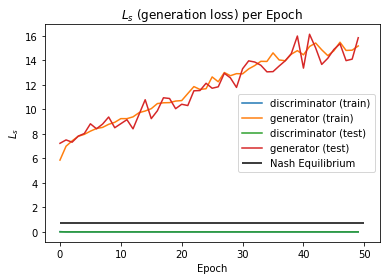

In [9]:
hist = pickle.load(open('../logs/acgan-history.pkl',"rb"))

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'generation_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.title(r'$L_s$ (generation loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')
plt.savefig('ACGAN generation loss.jpg')
plt.show()

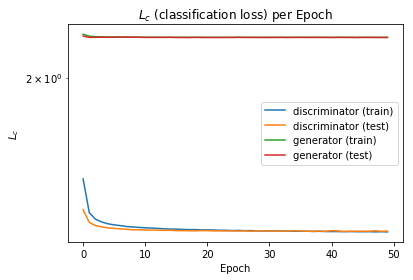

In [10]:
for g in ['discriminator', 'generator']:
    for p in ['train', 'test']:
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))

plt.legend()
plt.title(r'$L_c$ (classification loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.semilogy()
plt.savefig('ACGAN classification loss.jpg')
plt.show()